# Bike sharing demand forecast (on daily data)

Predict bike sharing demand as a function of seasonal and weather conditions.

Data origin:
- original full dataset (by hour, not used here): https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
- simplified dataset (by day, with some simple scaling): https://www.hds.utc.fr/~tdenoeux/dokuwiki/en/aec
    - description: https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/exam_2019_ace_.pdf
    - data: https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/bike_sharing_day.csv.zip
    
Note that even if we are estimating a time serie, we are not using here a recurrent neural network as we assume the temporal dependence to be negligible (i.e. Y_t = f(X_t) alone).

In [181]:
###########################################################################################
### With scaling of the X, correction of measure unit for Y & dummification (but no PCA)...
###########################################################################################

using LinearAlgebra, Random, DataFrames, CSV, StatsPlots, Distributions
using BetaML.Nn

import Random:seed!
seed!(123)

MersenneTwister(UInt32[0x0000007b], Random.DSFMT.DSFMT_state(Int32[1464307935, 1073116007, 222134151, 1073120226, -290652630, 1072956456, -580276323, 1073476387, 1332671753, 1073438661  …  138346874, 1073030449, 1049893279, 1073166535, -1999907543, 1597138926, -775229811, 32947490, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x0000000000000

In [199]:
# Data loading and cleaning..
baseDir = "assets/bikeSharingDemandForecast/"
data = CSV.read(joinpath(baseDir,"bike_sharing_day.csv"),delim=',',copycols=true)
describe(data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,instant,366.0,1,366.0,731,,,Int64
2,dteday,,2011-01-01,,2012-12-31,731,,Date
3,season,2.49658,1,3.0,4,,,Int64
4,yr,0.500684,0,1.0,1,,,Int64
5,mnth,6.51984,1,7.0,12,,,Int64
6,holiday,0.0287278,0,0.0,1,,,Int64
7,weekday,2.99726,0,3.0,6,,,Int64
8,workingday,0.683995,0,1.0,1,,,Int64
9,weathersit,1.39535,1,1.0,3,,,Int64


In [200]:
seasonDummies = convert(Array{Float64,2},oneHotEncoder(data[:,:season]))
weatherDummies = convert(Array{Float64,2},oneHotEncoder(data[:,:weathersit]))
wdayDummies = convert(Array{Float64,2},oneHotEncoder(data[:,:weekday] .+ 1 ))

x    = hcat(convert(Array{Float64,2},data[:,[:instant,:yr,:mnth,:holiday,:workingday,:temp,:atemp,:hum,:windspeed]]),
            seasonDummies,
            weatherDummies,
            wdayDummies)
y    = data[:,16] 
colsNotToScale = [2;4;5;10:23]

# Split the data in training/testing sets
ntrain    = Int64(round(size(x,1)*0.75))
nval      = Int64(round(size(x,1)*0.125))
ntest     = size(x,1) - (ntrain+nval)
xtrain    = x[1:ntrain,:]
ytrain    = y[1:ntrain]
xval      = x[(ntrain+1):(ntrain+nval),:]
yval      = y[(ntrain+1):(ntrain+nval)]
xtest     = x[ntrain+nval+1:end,:]
ytest     = y[ntrain+nval+1:end]

xScaleFactors = getScaleFactors(xtrain,skip=colsNotToScale)
yScaleFactors = ([0],[0.001]) # getScaleFactors(ytrain) # This just divide by 1000. Using full scaling of Y we may get negative demand.

xtrainScaled = Utils.scale(xtrain,xScaleFactors)

xvalScaled   = Utils.scale(xval,xScaleFactors)
xtestScaled  = Utils.scale(xtest,xScaleFactors)
ytrainScaled = Utils.scale(ytrain,yScaleFactors)
out    = pca(xtrainScaled,error=0.05)
xtrainScaledPca = xtrainScaled #out.X  # change these lines if you want to run PCA (doesn't seem to improve)
xvalScaledPca   = xvalScaled   #xvalScaled*out.P
xtestScaledPca  = xtestScaled  #xtestScaled*out.P
D = size(xtrainScaledPca,2)

23

In [201]:
# Train using validation set to select the hyperpharameters (may take a while)
epochsToTest = [10,20,40,80,160,320,640,1200]
hiddenLayerSizes = [5,8,12,15,20,25,30]
bestEpoch = 0
bestSize = 0
bestValError = Inf
errorsMatrix = fill(Inf64,length(epochsToTest),length(hiddenLayerSizes))

for (ne,epoch) in enumerate(epochsToTest), (nls,ls) in enumerate(hiddenLayerSizes)

    global bestValError, bestSize, errorsMatrix, bestEpoch
    println("Testing epochs $epoch, layer size $ls ...")
    # Note that the Xavier initialisation is now by default, so you don't need to specify w and wb to get it...
    l1   = DenseLayer(D,ls,f=sigmoid, w=rand(Uniform(-sqrt(6)/sqrt(D+ls),sqrt(6)/sqrt(D+ls)),ls,D), wb=rand(Uniform(-sqrt(6)/sqrt(D+ls),sqrt(6)/sqrt(D+ls)),ls)   ) # Activation function is ReLU
    l2   = DenseLayer(ls,1,f=relu, w=rand(Uniform(-sqrt(6)/sqrt(1+15),sqrt(6)/sqrt(1+15)),1,ls), wb=rand(Uniform(-sqrt(6)/sqrt(ls+1),sqrt(6)/sqrt(ls+1)),1) )
    mynn = buildNetwork([l1,l2],squaredCost,name="Bike sharing regression model") # Build the NN and use the squared cost (aka MSE) as error function

    # Training it (default to ADAM)
    res  = train!(mynn,xtrainScaledPca,ytrainScaled,epochs=epoch,batchSize=8,optAlg=ADAM(),verbosity=NONE) # Use optAlg=SGD() to use Stochastic Gradient Descent
    ŷval = Utils.scale(predict(mynn,xvalScaledPca),yScaleFactors,rev=true)
    
    meanRelErrorVal   = meanRelError(ŷval,yval)
    if meanRelErrorVal < bestValError
        bestValError = meanRelErrorVal
        bestSize = ls
        bestEpoch = epoch
    end
    errorsMatrix[ne,nls] = meanRelErrorVal
end

errorsMatrix

Testing epochs 10, layer size 5 ...
Testing epochs 10, layer size 8 ...
Testing epochs 10, layer size 12 ...
Testing epochs 10, layer size 15 ...
Testing epochs 10, layer size 20 ...
Testing epochs 10, layer size 25 ...
Testing epochs 10, layer size 30 ...
Testing epochs 20, layer size 5 ...
Testing epochs 20, layer size 8 ...
Testing epochs 20, layer size 12 ...
Testing epochs 20, layer size 15 ...
Testing epochs 20, layer size 20 ...
Testing epochs 20, layer size 25 ...
Testing epochs 20, layer size 30 ...
Testing epochs 40, layer size 5 ...
Testing epochs 40, layer size 8 ...
Testing epochs 40, layer size 12 ...
Testing epochs 40, layer size 15 ...
Testing epochs 40, layer size 20 ...
Testing epochs 40, layer size 25 ...
Testing epochs 40, layer size 30 ...
Testing epochs 80, layer size 5 ...
Testing epochs 80, layer size 8 ...
Testing epochs 80, layer size 12 ...
Testing epochs 80, layer size 15 ...
Testing epochs 80, layer size 20 ...
Testing epochs 80, layer size 25 ...
Testing e

8×7 Array{Float64,2}:
 1.0       0.382093  0.240301  0.243192  0.171008  0.149832  0.137392
 1.0       0.251639  0.160409  0.151328  0.142868  0.132148  0.125572
 0.177597  0.159122  0.129497  1.0       0.126658  0.125249  0.121652
 0.131814  0.118258  1.0       0.112977  0.122541  1.0       0.114029
 0.136996  1.0       0.142041  0.107474  0.115092  0.110302  1.0
 0.122078  0.182235  0.15017   0.11516   0.110813  0.124163  0.132251
 0.159641  0.156352  0.116423  0.163739  0.139957  0.181747  0.167154
 0.108502  0.194135  0.18298   1.0       0.153333  0.196052  1.0

In [202]:
# Re-doing training with the best hyperparameters:
ls    = bestSize
epoch = bestEpoch

println("Final training of $epoch epochs, with layer size $ls ...")
# Note that the Xavier initialisation is now by default, so you don't need to specify w and wb to get it...
l1   = DenseLayer(D,ls,f=sigmoid, w=rand(Uniform(-sqrt(6)/sqrt(D+ls),sqrt(6)/sqrt(D+ls)),ls,D), wb=rand(Uniform(-sqrt(6)/sqrt(D+ls),sqrt(6)/sqrt(D+ls)),ls)   ) # Activation function is ReLU
l2   = DenseLayer(ls,1,f=identity, w=rand(Uniform(-sqrt(6)/sqrt(1+15),sqrt(6)/sqrt(1+15)),1,ls), wb=rand(Uniform(-sqrt(6)/sqrt(ls+1),sqrt(6)/sqrt(ls+1)),1) )
mynn = buildNetwork([l1,l2],squaredCost,name="Bike sharing regression model") # Build the NN and use the squared cost (aka MSE) as error function

# Training it (default to ADAM)
res  = train!(mynn,xtrainScaledPca,ytrainScaled,epochs=epoch,batchSize=8,optAlg=ADAM()) # Use optAlg=SGD() to use Stochastic Gradient Descent

Final training of 160 epochs, with layer size 15 ...
***
*** Training Bike sharing regression model for 160 epochs with algorithm ADAM.
Training.. 	 avg ϵ on (Epoch 1 Batch 68): 	 4.759631907120926
Training.. 	 avg ϵ on (Epoch 16 Batch 68): 	 0.6266792494135905


Training the Neural Network... 19%|████                 |  ETA: 0:00:04

Training.. 	 avg ϵ on (Epoch 32 Batch 68): 	 0.6855875177826604
Training.. 	 avg ϵ on (Epoch 48 Batch 68): 	 0.09553278109924862


Training the Neural Network... 37%|███████▊             |  ETA: 0:00:03

Training.. 	 avg ϵ on (Epoch 64 Batch 68): 	 0.10137874714414602
Training.. 	 avg ϵ on (Epoch 80 Batch 68): 	 0.07149740208286708


Training the Neural Network... 56%|███████████▋         |  ETA: 0:00:02

Training.. 	 avg ϵ on (Epoch 96 Batch 68): 	 0.21400924620251138
Training.. 	 avg ϵ on (Epoch 112 Batch 68): 	 0.323271439299172


Training the Neural Network... 71%|███████████████      |  ETA: 0:00:02

Training.. 	 avg ϵ on (Epoch 128 Batch 68): 	 0.10852062881785637


Training the Neural Network... 90%|██████████████████▉  |  ETA: 0:00:01

Training.. 	 avg ϵ on (Epoch 144 Batch 68): 	 0.12881011082541632


Training the Neural Network...100%|█████████████████████| Time: 0:00:05


Training.. 	 avg ϵ on (Epoch 160 Batch 68): 	 0.03386064741975414
Training of 160 epoch completed. Final epoch error: 0.11496579043347893.


(epochs = 160, ϵ_epochs = [12.259771928568133, 9.118963653392784, 6.567900130242088, 4.499065072221751, 2.8877457006108798, 1.8664376887157044, 1.2475228783555008, 0.9138042220112002, 0.7241436524161727, 0.6072520151822504  …  0.11868994605784906, 0.11836356984675837, 0.11819742713169665, 0.11748352185124447, 0.1176864083661754, 0.11677244231220515, 0.11645001163784727, 0.11609687925439012, 0.11677597192974083, 0.11496579043347893], θ_epochs = Any[])

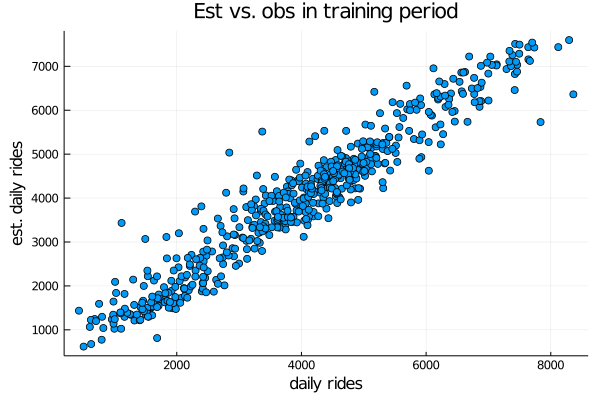

In [203]:
ŷtrain  = max.(0.0,Utils.scale(predict(mynn,xtrainScaledPca),yScaleFactors,rev=true))
scatter(ytrain,ŷtrain,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in training period")

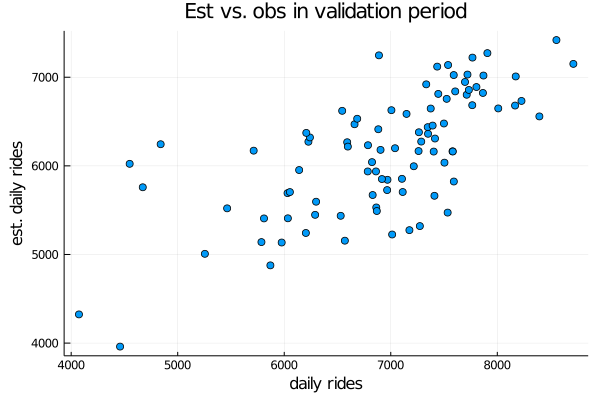

In [204]:
ŷval = max.(0.0,Utils.scale(predict(mynn,xvalScaledPca),yScaleFactors,rev=true))
scatter(yval,ŷval,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in validation period")

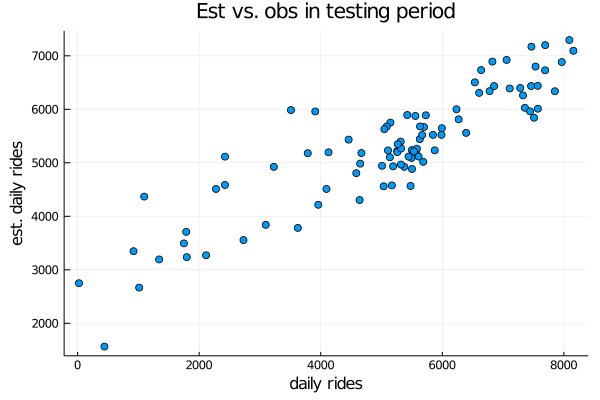

In [205]:
ŷtest  = max.(0.0,Utils.scale(predict(mynn,xtestScaledPca),yScaleFactors,rev=true))
scatter(ytest,ŷtest,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in testing period")

In [206]:
mean(abs.(ŷtest .- ytest))/mean(ytest)

0.1535623552747234

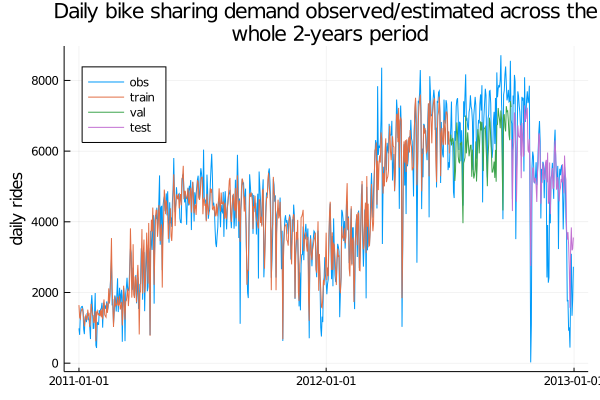

In [207]:
# Full period plot (2 years)
ŷtrainfull = vcat(ŷtrain,fill(missing,nval+ntest))
ŷvalfull = vcat(fill(missing,ntrain), ŷval, fill(missing,ntest))
ŷtestfull = vcat(fill(missing,ntrain+nval), ŷtest)
plot(data[:,:dteday],[data[:,:cnt] ŷtrainfull ŷvalfull ŷtestfull], label=["obs" "train" "val" "test"], legend=:topleft, ylabel="daily rides", title="Daily bike sharing demand observed/estimated across the\n whole 2-years period")

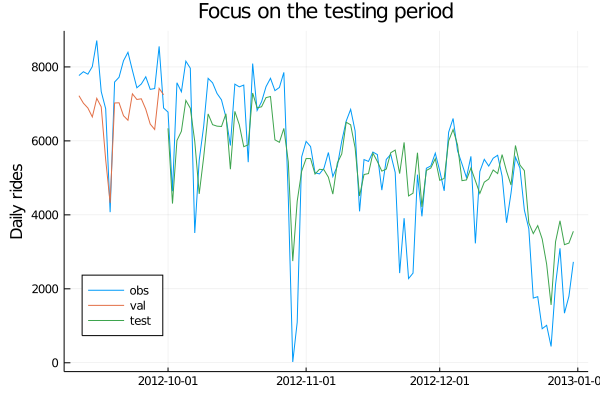

In [208]:
# Focus on testing data
stc = 620
endc = size(x,1)
plot(data[stc:endc,:dteday],[data[stc:endc,:cnt] ŷvalfull[stc:endc] ŷtestfull[stc:endc]], label=["obs" "val" "test"], legend=:bottomleft, ylabel="Daily rides", title="Focus on the testing period")

## Comparation with Flux

Disclaimer: I'm a nebbie with [Flux](https://fluxml.ai/), this is likelly not to be the best approach

In [209]:
using Flux

In [210]:
# Defining the net model and load it with data...
Flux_nn = Chain(Dense(D,ls,Flux.sigmoid),
                Dense(ls,1,identity))

loss(x, y) = Flux.mse(Flux_nn(x), y)
ps = Flux.params(Flux_nn)
nndata = Flux.Data.DataLoader(xtrainScaledPca', ytrainScaled', batchsize=8,shuffle=true) 

Flux.Data.DataLoader(([-1.728893009486523 -1.722571645649278 … 1.722571645649278 1.728893009486523; 0.0 0.0 … 1.0 1.0; … ; 0.0 0.0 … 0.0 0.0; 1.0 0.0 … 1.0 0.0], [0.985 0.801 … 5.687 5.531]), 8, 548, true, 548, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  539, 540, 541, 542, 543, 544, 545, 546, 547, 548], true)

In [211]:
# Training of the Flux model...
Flux.@epochs epoch Flux.train!(loss, ps, nndata, Flux.ADAM(0.001, (0.9, 0.8)))

┌ Info: Epoch 1
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 2
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 3
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 4
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 5
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 6
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 7
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 8
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 9
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 10
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 11
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/s

┌ Info: Epoch 89
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 90
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 91
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 92
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 93
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 94
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 95
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 96
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 97
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 98
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 99
└ @ Main /home/lobianco/.julia/packages/Flu

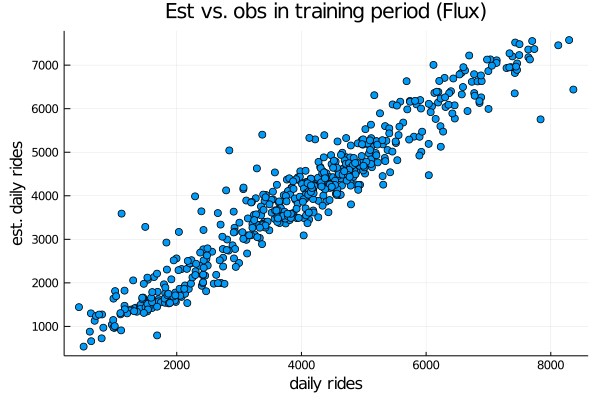

In [212]:
ŷtrainf = max.(0.0,Utils.scale(Flux_nn(xtrainScaledPca')',yScaleFactors,rev=true))
scatter(ytrain,ŷtrainf,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in training period (Flux)")

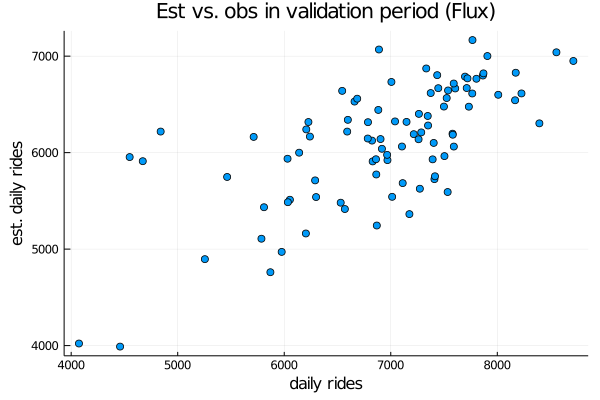

In [213]:
ŷvalf = max.(0.0,Utils.scale(Flux_nn(xvalScaledPca')',yScaleFactors,rev=true))
scatter(yval,ŷvalf,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in validation period (Flux)")

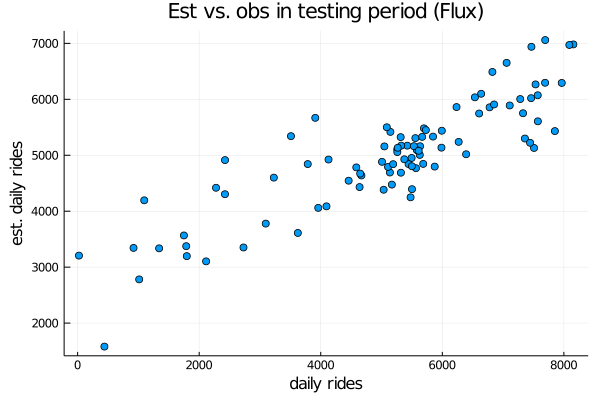

In [214]:
ŷtestf  = max.(0.0,Utils.scale(Flux_nn(xtestScaledPca')',yScaleFactors,rev=true))
scatter(ytest,ŷtestf,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in testing period (Flux)")

In [215]:
mean(abs.(ŷtestf .- ytest))/mean(ytest)

0.18006296062994867

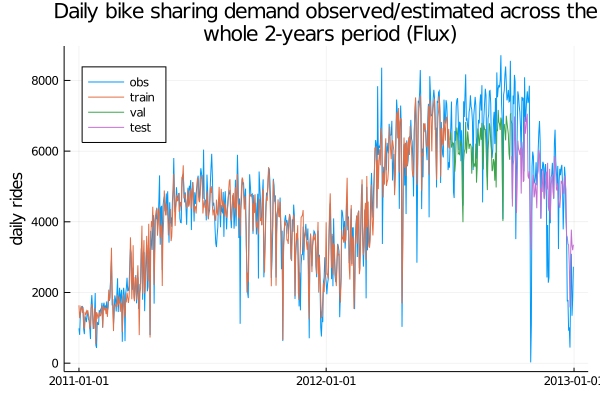

In [216]:
# Full period plot (2 years)
ŷtrainfullf = vcat(ŷtrainf,fill(missing,nval+ntest))
ŷvalfullf = vcat(fill(missing,ntrain), ŷvalf, fill(missing,ntest))
ŷtestfullf = vcat(fill(missing,ntrain+nval), ŷtestf)
plot(data[:,:dteday],[data[:,:cnt] ŷtrainfullf ŷvalfullf ŷtestfullf], label=["obs" "train" "val" "test"], legend=:topleft, ylabel="daily rides", title="Daily bike sharing demand observed/estimated across the\n whole 2-years period (Flux)")

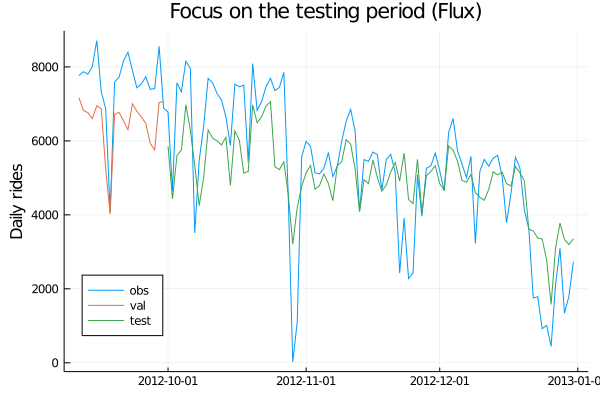

In [218]:
# Focus on testing data
stc = 620
endc = size(x,1)
plot(data[stc:endc,:dteday],[data[stc:endc,:cnt] ŷvalfullf[stc:endc] ŷtestfullf[stc:endc]], label=["obs" "val" "test"], legend=:bottomleft, ylabel="Daily rides", title="Focus on the testing period (Flux)")